In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data as data
import torch.nn.functional as F
import torch.optim as optim

from models import *
from learning import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
narma_df = pd.read_csv('../NARMA10.csv', header=None)
narma_df.iloc[:, :20] # visualize the first 20 columns

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.083964,0.48934,0.35635,0.25024,0.23554,0.029809,0.34099,0.021216,0.035723,0.26082,0.048365,0.40907,0.40877,0.36122,0.074933,0.32980,0.25930,0.48649,0.32450,0.40017
1,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.132850,0.17536,0.37127,0.36481,0.337070,0.20447,0.33003,0.20726,0.18825,0.28343


In [3]:
x_data = torch.tensor(narma_df.iloc[0].values, dtype=torch.float32) # float 32 for better memory efficiency
y_data = torch.tensor(narma_df.iloc[1].values, dtype=torch.float32)

# 4000 tr, 1000 val, 5000 test (WARNING: load entire dataset in memory ONLY because it is small and also the NN is quite small)
train_x, test_x = x_data[:5000].to(device), x_data[5000:].to(device)
train_y, test_y = y_data[:5000].to(device), y_data[5000:].to(device)

train_x, val_x = train_x[:4000].to(device), train_x[4000:].to(device)
train_y, val_y = train_y[:4000].to(device), train_y[4000:].to(device)

In [4]:
first_hyperparams = {
    'batch_size': [100],
    'lr':  [0.001, 0.003, 0.005, 0.01, 0.03, 0.05],
    'weight_decay': [0, 1e-5, 1e-7],
    'epochs': [15, 20],
    'window_size': [10, 20, 30],
    'hidden_size': [20, 30, 50],
}

grid_tdnn = GridSearch(first_hyperparams)

model_selection_history = grid_tdnn.tdnn_grid_search(train_x, train_y, val_x, val_y, verbose=False)

Configuration 0
Configuration 1
Configuration 2
Configuration 3
Configuration 4
Configuration 5
Configuration 6
Configuration 7
Configuration 8
Configuration 9
Configuration 10
Configuration 11
Configuration 12
Configuration 13
Configuration 14
Configuration 15
Configuration 16
Configuration 17
Configuration 18
Configuration 19
Configuration 20
Configuration 21
Configuration 22
Configuration 23
Configuration 24
Configuration 25
Configuration 26
Configuration 27
Configuration 28
Configuration 29
Configuration 30
Configuration 31
Configuration 32
Configuration 33
Configuration 34
Configuration 35
Configuration 36
Configuration 37
Configuration 38
Configuration 39
Configuration 40
Configuration 41
Configuration 42
Configuration 43
Configuration 44
Configuration 45
Configuration 46
Configuration 47


In [5]:
df = pd.DataFrame.from_dict(model_selection_history, orient='index')
df.to_csv('grid_tdnn_search.csv')
df.sort_values(by='val_mse', ascending=True).head(10)

,batch_size,lr,weight_decay,epochs,window_size,hidden_size,train_mse,val_mse,val_mae
config_21,100,0.005,0,20,20,30,0.000174,0.000461,0.010817
config_27,100,0.010,0,15,20,30,0.000164,0.000493,0.011015
config_45,100,0.050,0,20,20,30,0.000142,0.000494,0.011636
config_20,100,0.005,0,20,20,20,0.000236,0.000522,0.012519
config_29,100,0.010,0,15,30,30,0.000142,0.000526,0.010514
config_41,100,0.050,0,15,30,30,0.000424,0.000639,0.016685
config_26,100,0.010,0,15,20,20,0.000445,0.000641,0.017086
config_33,100,0.010,0,20,20,30,0.000404,0.000646,0.017717
config_35,100,0.010,0,20,30,30,0.000122,0.000678,0.012417
config_8,100,0.001,0,20,20,20,0.000419,0.000683,0.017155


In [13]:
tdnn = TDNN(window_size=20, hidden_size=30, output_size=1).to(device)
train_dataset = TDNNDataset(train_x, train_y, window_size=20)
val_dataset = TDNNDataset(val_x, val_y, window_size=20)
train_loader = data.DataLoader(train_dataset, batch_size=100, shuffle=False)
val_loader = data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
t_h, val_h, mae = train_tdnn(tdnn, train_loader, val_loader, lr=0.005, weight_decay=0, epochs=20)

Epoch 0 - Train MSE: 0.01932342761429027 - Val MSE: 0.006626038812100887
Epoch 1 - Train MSE: 0.0049547370697837325 - Val MSE: 0.004604116547852755
Epoch 2 - Train MSE: 0.0032948951062280684 - Val MSE: 0.0029141115956008434
Epoch 3 - Train MSE: 0.0019813077640719714 - Val MSE: 0.0017923619598150253
Epoch 4 - Train MSE: 0.0012639729655347764 - Val MSE: 0.0014158206759020686
Epoch 5 - Train MSE: 0.0010589290599455126 - Val MSE: 0.001309055252932012
Epoch 6 - Train MSE: 0.0009877485892502591 - Val MSE: 0.0012443759478628635
Epoch 7 - Train MSE: 0.000934978223813232 - Val MSE: 0.0011680311290547252
Epoch 8 - Train MSE: 0.0008758575830142945 - Val MSE: 0.0010841822950169444
Epoch 9 - Train MSE: 0.0008067395690886769 - Val MSE: 0.0009890166111290455
Epoch 10 - Train MSE: 0.0007319300522794947 - Val MSE: 0.0008994893287308514
Epoch 11 - Train MSE: 0.0006612427918298635 - Val MSE: 0.0008329486008733511
Epoch 12 - Train MSE: 0.0006005300281685777 - Val MSE: 0.000776963890530169
Epoch 13 - Train

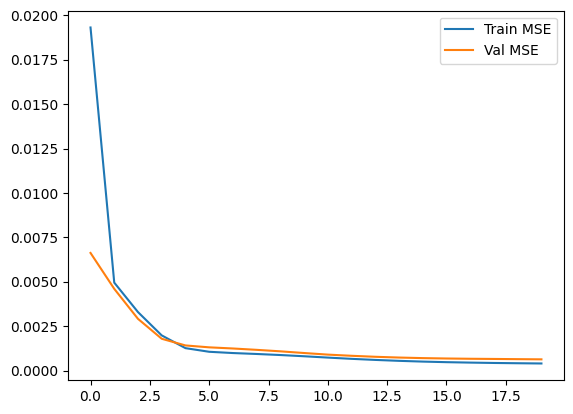

In [14]:
# this code is just a try to see how to plot
plt.plot(t_h, label='Train MSE')
plt.plot(val_h, label='Val MSE')
plt.legend()

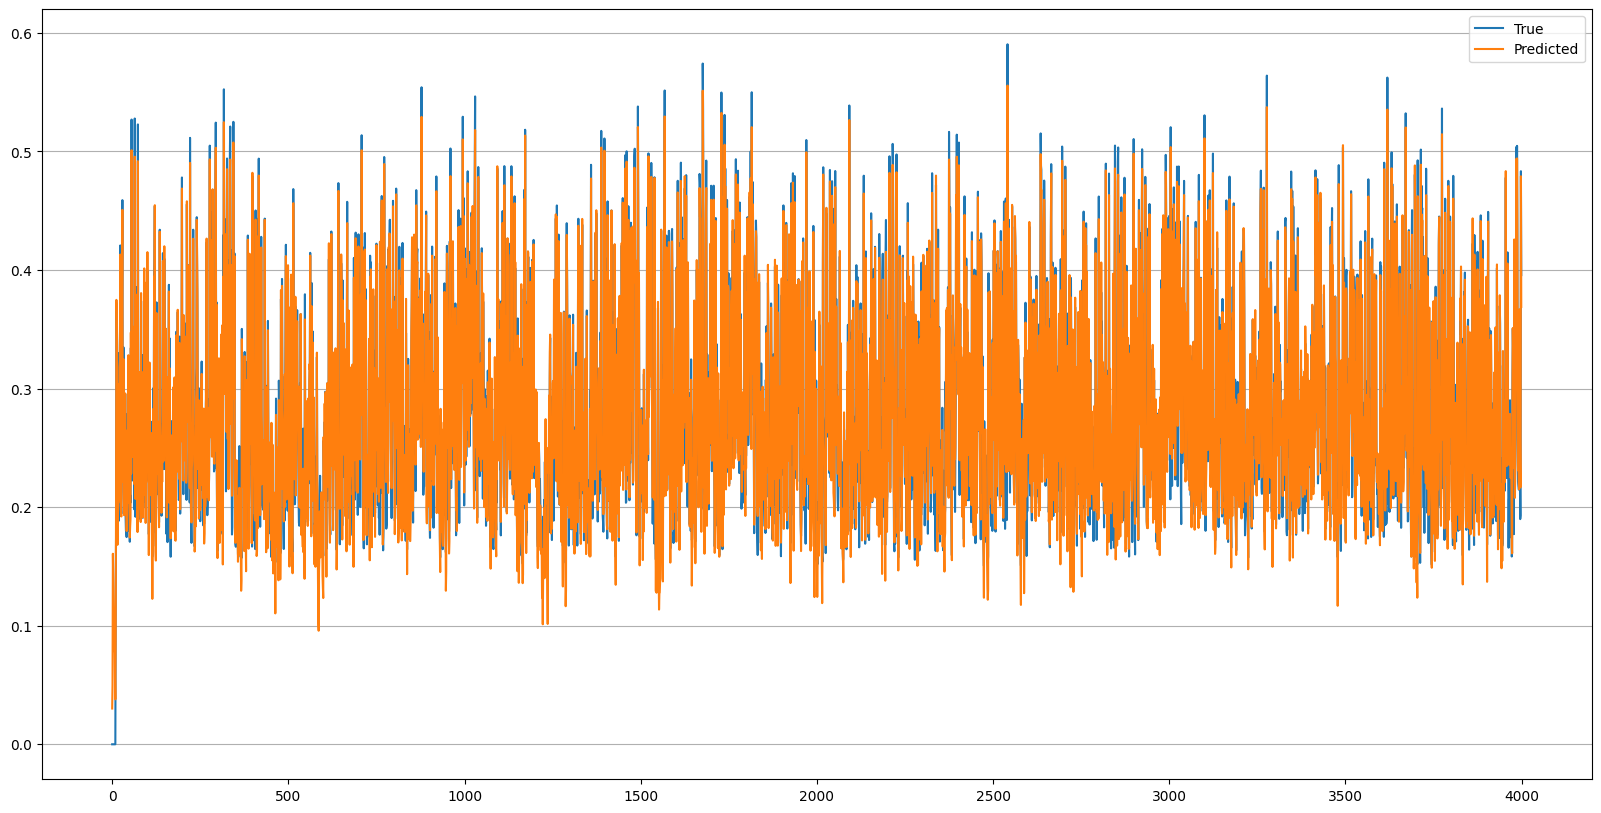

In [16]:
# this code is just a try to see how to plot
train_loader = data.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
plt.figure(figsize=(20, 10))
plt.grid(True, axis='y')
for x, y in train_loader:
    with torch.no_grad():
        out = tdnn(x)
        plt.plot(y.cpu().numpy(), label='True')
        plt.plot(out.cpu().numpy(), label='Predicted')
        plt.legend()
        plt.show()